In [1]:
## Семинар 1 "Полносвязные нейронные сети"

**ФИО:** Петряйкин Федор Алексеевич

В этом задании вам предстоит реализовать проход "вперед" для полносвязной нейронную сети. В дальнейшем мы реализуем процедуру обучения и научим сеть распознавать рукописные цифры.

На первой лекции мы познакомились с тем, что такое нейронные сети и изучили три слоя — линейный, сигмоида и SoftMax. Из этих слоев можно составлять глубокие архитектуры и обучать их при помощи градиентного спуска. Чтобы конструировать сложные архитектуры, можно реализовать каждый тип слоя как отдельный "кирпичик" и затем собирать полную архитектуру как конструктор. Это мы и попробуем сделать на первом и втором семинарах.

Каждый тип слоя мы будем реализовывать при помощи класса, который будет поддерживать три функции: forward, которая будет применять функцию, реализуемую слоем, к входной матрице и backward, которая будет вычислять градиенты и step, которая будет обновлять веса. Чтобы не применять функцию к каждому объекту в отдельности, мы будем подавать на вход слою матрицу размера (N, d), где N — количество объектов, а d — размерность каждого объекта.

<img src=backprop.png width=400>

Функция forward будет вычислять по $x$ значение $y$, backward — по $\frac{\partial L}{\partial y}$ вычислять $\frac{\partial L}{\partial x}$ и обновлять внутри себя $\frac{\partial L}{\partial w}$.

Важным требованием к реализации является векторизация всех слоев: все операции должны быть сведены к матричным, не должно быть циклов. Это значительно уменьшает временные затраты.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### Часть 1: Линейный слой


Приведем пример вычисления градиентов для линейного слоя: $y = xW$, $x \in \mathbb{R}^{K \times n}$, $y \in \mathbb{R}^{K \times m}$, $W \in \mathbb{R}^{n \times m}$, где $K$ — число объектов.

Рассмотрим $L$ как функцию от выходов нейронной сети: $L = L(y_{11}, y_{12}, \dots)$

$$y_{kt} = (xW)_{kt} = \sum_{z=1}^{n} x_{kz}W_{zt}$$

$$\frac{\partial L}{\partial x_{ij}} = \sum_{kt} \frac{\partial L}{\partial y_{kt}}\frac{\partial y_{kt}}{\partial x_{ij}} = \sum_{kt} \frac{\partial L}{\partial y_{kt}}\frac{\partial \sum_z x_{kz}w_{zt}}{\partial x_{ij}}= \sum_{t} \frac{\partial L}{\partial y_{it}}w_{jt}$$

$$\frac{\partial{L}}{\partial x} = \frac{\partial{L}}{\partial y}W^T$$

In [2]:
class Linear:
    def __init__(self, input_size, output_size, W0=None, b0=None):
        '''
        Creates weights and biases for linear layer.
        Dimention of inputs is *input_size*, of output: *output_size*.
        '''
        #### YOUR CODE HERE
        #### Create weights, initialize them with samples from N(0, 0.1).
        self.input_size = input_size
        self.output_size = output_size
        
        self.W0 = W0
        self.b0 = b0
        
        self.clear()

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, input_size).
        Returns output of size (N, output_size).
        Hint: You may need to store X for backward pass
        '''
        self.X = X
        return X.dot(self.W)+self.b

    def backward(self, dLdy): #Считаем градиент на нейроне
        '''
        1. Compute dLdw and dLdx.
        2. Store dLdw for step() call
        3. Return dLdx
        '''
        self.dLdW = self.X.T.dot(dLdy)
        self.dLdb = dLdy.sum(0)
        self.dLdx = dLdy.dot(self.W.T)
        return self.dLdx

    def step(self, learning_rate):
        '''
        1. Apply gradient dLdw to network:
        w <- w - learning_rate*dLdw
        '''
        self.W = self.W - learning_rate * self.dLdW
        self.b = self.b - learning_rate * self.dLdb
        
    def clear(self):
        if not self.W0 is None:
            self.W = self.W0
        else:
            self.W = np.random.randn(self.input_size, self.output_size)*0.01 #Случайные коэффициенты с дисперсией 0.1
        
        if not self.b0 is None:
            self.b = self.b0
        else:
            self.b = np.zeros(self.output_size)

In [3]:
lin = Linear(10, 2)
X = np.ones((5, 10))
y = lin.forward(X)
dLdy = np.ones((5, 2))
lin.backward(dLdy).shape, lin.dLdW.shape, lin.dLdb.shape

((5, 10), (10, 2), (2,))

### Часть 2: Численный градиент

Релизуйте функцию проверки численного градиента. Для этого для каждой переменной, по которой считается градиент, надо вычислить численный градиент: $f'(x) \approx \frac{f(x+\epsilon)-f(x-\epsilon)}{2\epsilon}$. Функция должна возвращать максимальное абсолютное отклонение аналитического градиента от численного. В качестве $\epsilon$ рекомендуется взять $10^{-6}$. При правильной реализации максимальное отличие будет иметь порядок $10^{-8}-10^{-6}$.

In [5]:
def check_gradient(func, X, gradient, eps = 1e-5):
    '''
    Computes numerical gradient and compares it with analytcal.
    func: callable, function of which gradient we are interested. Example call: func(X) - numeric function!
    X: np.array of size (n x m)
    gradient: np.array of size (n x m)
    Returns: maximum absolute diviation between numerical gradient and analytical.
    '''
    numerical_gradient = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X[i, j] += eps
            y1 = func(X)
            X[i, j] -= 2*eps
            y2 = func(X)
            X[i, j] += eps
            numerical_gradient[i, j] = (y1-y2)/2/eps
    
    print(np.abs(numerical_gradient - gradient).max())

In [6]:
func = lambda x: (x**2).sum() # Хотим скалярную функцию ошибок, а check_gradient проверяет по очереди всю матрицу

In [7]:
x = np.random.rand(10, 20)
gradient = 2*x
check_gradient(func, x, gradient)

8.817004903960424e-10


Протестируйте линейный слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$ и $\frac{\partial L}{\partial w}$.

In [15]:
lin = Linear(10, 2)
X = np.ones((5, 10))
y = lin.forward(X)
print(y)

func = lambda x: lin.forward(x).sum() # Аналог функции ошибок
dLdy = np.ones((5, 2)) # Очевидно, что производная суммы по всем y = 1
gradient = lin.backward(dLdy)
check_gradient(func, X, gradient)

[[-0.00894676  0.00014247]
 [-0.00894676  0.00014247]
 [-0.00894676  0.00014247]
 [-0.00894676  0.00014247]
 [-0.00894676  0.00014247]]
3.953001120882149e-13


In [9]:
lin = Linear(10, 2)
X = np.ones((5, 10))
y = lin.forward(X)
def func(W):
    W_old = lin.W
    lin.W = W
    y = lin.forward(X).sum()
    lin.W = W_old
    return y

dLdy = np.ones((5, 2))
W = lin.W
lin.backward(dLdy)
gradient = lin.dLdW
check_gradient(func, W, gradient)

1.93889349021e-12


### Часть 3: Сигмоида

In [10]:
class Sigmoid:
    def __init__(self):
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.s = 1.0/(1+np.exp(-X))
        return self.s
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return self.s*(1-self.s)*dLdy
    
    def step(self, learning_rate):
        pass
    
    def clear(self):
        pass

Протестируйте слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$.

In [11]:
X = np.ones((5, 10))
s = Sigmoid()
def func(X):
    return s.forward(X).sum()

dLdy = np.ones((5, 10))
s.forward(X)
gradient = s.backward(dLdy)
check_gradient(func, X, gradient)

1.07232139834e-10


### Часть 4: Функция потерь

Как мы увидели на семинаре, вычисление производной для связки SoftMax + Negative log-likelihood проще чем для этих двух слоев по отдельности. Поэтому мы реализуем их как один класс. Важное замечание: на проходе "вперед" важно воспользоваться трюком <a href="https://hips.seas.harvard.edu/blog/2013/01/09/computing-log-sum-exp/">log-sum-exp</a>, чтобы не столкнуться с численными неустойчивостями.

In [12]:
a = np.random.rand(10, 4)

In [13]:
b = np.random.randint(0, 4, 10)

In [14]:
class SoftMax_NLLLoss:
    def __init__(self):
        '''
        Applies Softmax operation to inputs and computes NLL loss
        '''
        pass
    
    # Рассчитывает последний узел и подготавливает данные для расчета ошибки
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, C), where C is the number of classes
        Returns SoftMax for all X
        '''
        #SoftMax
        self.p = np.exp(X)
        self.p /= self.p.sum(1, keepdims=True)
        return self.p
     
    # Возвращает саму функцию ошибок - нужна только для отладки и графиков
    def getloss(self, y):
        self.y = np.zeros(self.p.shape) #Соответствует форме X
        self.y[np.arange(self.p.shape[0]), y] = 1
        
        #Функция потерь = среднее от потерь на всех объектах => в backward деление на X.shape[0]
        return -(np.log(self.p)*self.y).sum(1).mean(0) 
    
    # Это особый (конечный) слой => dLdy = y
    # Расчитывает производную фукции ошибки по входным данным конечного узла
    def backward(self, y):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        self.getloss(y)
        return (self.p - self.y) / self.p.shape[0]
    
    def step(self, learning_rate):
        pass
    
    def clear(self):
        pass

Протестируйте слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$.

In [15]:
X = np.random.rand(15, 4)
y = np.random.randint(0, 4, 15)

In [16]:
loss = SoftMax_NLLLoss()
def func(x):
    loss.forward(x)
    return loss.getloss(y)

loss.forward(X)
check_gradient(func, X, loss.backward(y))

1.53853631224e-11


### Часть 5, нейронная сеть

Теперь, когда у нас есть "кирпичики", мы можем написать класс, который будет собирать всю сеть вместе 

In [17]:
# Из-за того, что эти SoftMax и NLLLoss неразделимы, приходится предсусматривать в нейронной сети 2 возможности:
# работы с функцией потерь отдельно и в составе последнего нейрона
class NeuralNetwork:
    def __init__(self, modules, loss_function=None):
        '''
        Constructs network with *modules* as its layers
        loss_fuction - if the last neuron cannot calculate dLdy from y(_true)
        '''
        self.modules = modules
        self.loss_function = loss_function
    
    def forward(self, X):
        y_pred = X
        for i in xrange(len(self.modules)):
            y_pred = self.modules[i].forward(y_pred)
            
        # Функция потерь должна запомнить предсказания, чтобы потом по ним расчитать градиент
        if not (self.loss_function is None):
            self.loss_function.forward(y_pred)
        return y_pred
    
    def backward(self, y):
        '''
        y is true labels. The last neuron (or self.loss_function if avaliable) should calculate dLdy from y(_true)
        '''
        if not (self.loss_function is None):
            dLdy = self.loss_function.backward(y)
        else:
            dLdy = y
            
        for i in xrange(len(self.modules)-1, -1, -1): #Последний элемент не включается в xrange
            dLdy = self.modules[i].backward(dLdy)
        
    # Возвращает значение функции ошибок после обучения
    def getloss(self, y):
        if not (self.loss_function is None):
            return self.loss_function.getloss(y)
        else:
            return self.modules[-1].getloss(y)
    
    def step(self, learning_rate):
        for i in xrange(len(self.modules)):
            self.modules[i].step(learning_rate)
            
    def clear(self):
        for i in xrange(len(self.modules)):
            self.modules[i].clear()

### Часть 6, обучение на простых данных

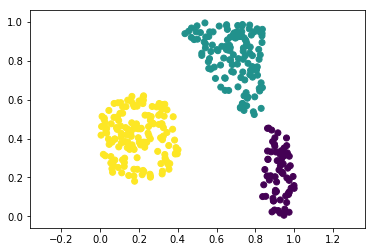

In [18]:
data = np.load('data.npz')
X, y = data['arr_0'], data['arr_1']
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis('equal')
plt.show()

Обучите архитектуру вида 2 -> 10 -> 10 -> 3:
* Linear(2, 10)
* Sigmoid()
* Linear(10, 10)
* Sigmoid()
* Linear(10, 3)

В качестве функции потерь используйте NLLLoss.
1. Создайте сеть, в цикле запускайте forward, backward, step (используйте learning rate 0.005). 
2. Нарисуйте график сходимости (величина NLL после каждого обновления).
3. Нарисуйте разделяющую поверхность
4. Попробуйте подобрать темп обучения. Как меняется сходимость?

In [19]:
arc = [Linear(2, 3), Sigmoid(), Linear(3, 3), SoftMax_NLLLoss()]
network = NeuralNetwork(arc)

In [20]:
def LearnNetwork(network, X, y, learning_rate=0.1, iterations=16000):
    network.clear()
    losses = []
    for i in range(iterations):
        prediction = network.forward(X)
        loss = network.getloss(y)

        losses.append(loss)
        network.backward(y)
        network.step(learning_rate)
    return losses

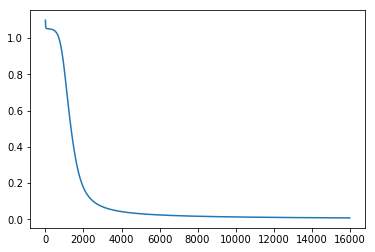

In [21]:
losses = LearnNetwork(network, X, y)
plt.plot(losses)

In [22]:
def PlotMeshWithScatter(X, y, pred_func, N=50, additional=0.15):
    '''
    pred_func(mesh) - returns classes from mesh grid
    '''
    delta_x = (np.max(X[:, 0])-np.min(X[:, 0]))*additional
    delta_y = (np.max(X[:, 1])-np.min(X[:, 1]))*additional
    
    x_grid = np.linspace(np.min(X[:, 0])-delta_x, np.max(X[:, 0])+delta_x, N)
    y_grid = np.linspace(np.min(X[:, 1])-delta_y, np.max(X[:, 1])+delta_y, N)
    X_mesh, Y_mesh = np.meshgrid(x_grid, y_grid)
    mesh = np.dstack((X_mesh, Y_mesh)).reshape(N*N, 2)
    
    predictions = pred_func(mesh)
    
    plt.scatter(mesh[:, 0], mesh[:, 1], c=predictions, alpha=0.2)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.axis('equal')
    plt.show()

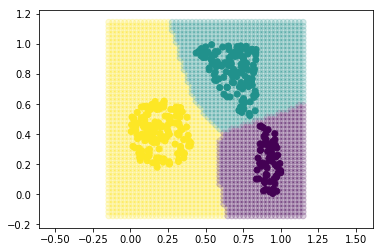

In [23]:
PlotMeshWithScatter(X, y, lambda x: np.argmax(network.forward(x), 1))

Отличная визуализация: http://playground.tensorflow.org/

## Домашнее задание:

* Подоберите темп обучения. Как меняется сходимость? Нарисуйте график оптимального значения функции потерь для различных значений learning_rate
* Решите поставленную выше задачу как задачу регрессии с MSE. Изменилась ли разделяющая поверхность?

**1. Темп обучения**

[  0.01         0.05623413   0.31622777   1.77827941  10.        ]
[0.50288623034104674, 0.014403669676917818, 0.0023821760308754048, 0.00042811583912397399, 5.2599490834364027e-05]


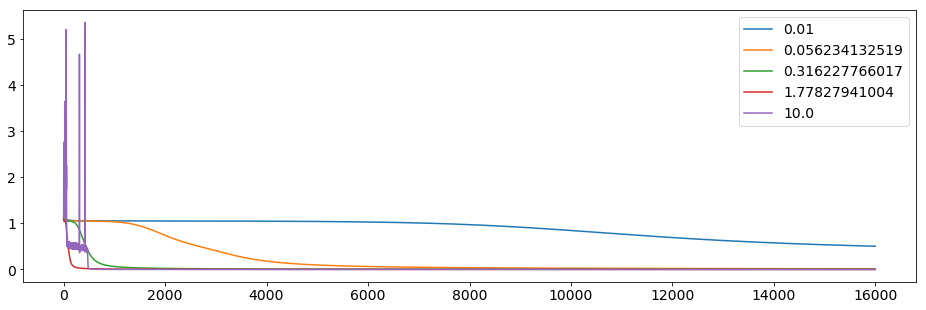

In [24]:
### YOUR CODE HERE:
learing_rates_array = np.logspace(start=-2, stop=1, num=5)
print learing_rates_array

final_losses = []
plt.rc('font', size=14)
plt.figure(figsize=(16,5))

for learning_rate in learing_rates_array:
    losses = LearnNetwork(network, X, y, learning_rate)
    plt.plot(losses, label=learning_rate)
    final_losses.append(losses[-1])
    
print final_losses
plt.legend()
plt.show()

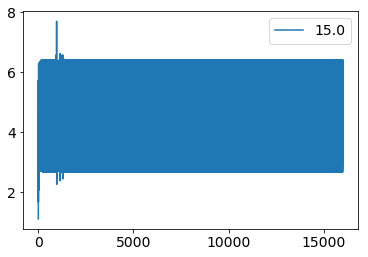

In [32]:
loss = LearnNetwork(network, X, y, 15.0)
plt.plot(loss, label=15.0)
plt.legend()

Таким образом видно, что при темпе 0.01 обучение сходится очень медленно, при темпах 0.07 - 1.77 сходится достаточно быстро, при темпе 10 схождение может не достигаться (очень большие колебания), при темпе >10 алгоритм не сходится

<Container object of 4 artists>

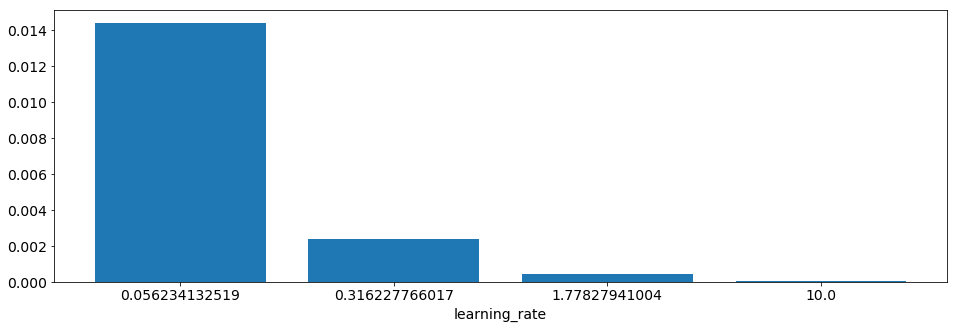

In [26]:
plt.figure(figsize=(16,5))
plt.xlabel("learning_rate")
plt.xticks(np.arange(len(final_losses)-1), learing_rates_array[1:])
plt.bar(np.arange(len(final_losses)-1), final_losses[1:])


Видно, что с learning_rate = 10 алгоритм сходится быстрее всего

**2. MSE**

In [27]:
# MSE для векторов
class MSE_Error:
    # Получает результат работы нейросети и запоминает его для расчета функции ошибок
    def forward(self, X):
        self.X = X
    
    # Возвращает производную функции ошибок по результату работы нейросети
    def backward(self, y):
        return -2*(y[np.newaxis].T-self.X)/self.X.shape[0]
    
    # Возвращает функцию ошибок
    def getloss(self, y):
        return ((self.X-y[np.newaxis].T)*(self.X-y[np.newaxis].T)).sum()/self.X.shape[0]

In [28]:
arc = [Linear(2, 5), Sigmoid(), Linear(5, 3), Sigmoid(), Linear(3, 1)]
network_mse = NeuralNetwork(arc, MSE_Error())

0.000246194931008


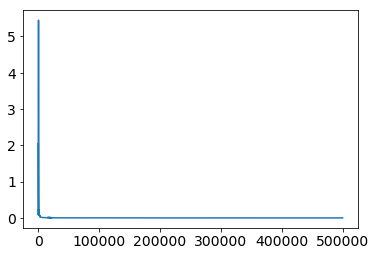

In [29]:
losses = LearnNetwork(network_mse, X, y, iterations=500000, learning_rate=0.5)
plt.plot(losses)
print losses[-1]

In [1]:
#MSE
PlotMeshWithScatter(X, y, lambda x: np.around(network_mse.forward(x), 1))

NameError: name 'PlotMeshWithScatter' is not defined

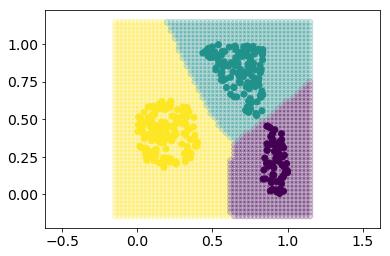

In [31]:
#SoftMax
LearnNetwork(network, X, y)
PlotMeshWithScatter(X, y, lambda x: np.argmax(network.forward(x), 1))

Границы имеют другие формы, отмечается небольшой шум на границе.